![GEE_ML](./Images/GEE_ML_Hydrological_Cycle.jpg)

# Evaluating Hydrological Model Performance

In the previous two chapters, we learned how to retrieve
* catchment information using StreamStats
* streamflow observations from NWIS
* NLDAS remote sensing data products using Google Earth Engine

Using this data, we processed it into a daily temporal resolution dataframe that supported the training and optimization of an XGBoost machine learning model.
We trained a standard model on three years of the daily data (2020-2022) using a randomized train/test split of 66/33%, i.e., training the model on 66% of the data and evaluating model performance on the remaining 33%.
For model performance, we used the metrics of KGE, Percent Bias, Mean Absolute Percentage Error, and root-mean-squared-error.

We then used the GridSearch CV function to optimize the hyperparameters of the XGBoost algorithm, observing small improvements in model skill.

In this final lesson, we will combine the skills from the previous two to develop a model prediction workflow, as well as evaluate the prediction skill of the models to unseen data.

In [72]:
#Load necessary packages
from hydrotools.nwis_client.iv import IVDataService
from hydrotools.nwm_client import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Get_StreamStats
from scipy import optimize
from datetime import datetime, date
import pickle
import joblib
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def NWIS_retrieve(site, startDT, endDT):
    service = IVDataService()
    usgs_data = service.get(
        sites=site,
        startDT= startDT,
        endDT= endDT
        )
    return usgs_data    

from platform import python_version

print(python_version())

3.9.12


## Building the Prediction DataFrame
We will be making streamflow predictions for our test location of Red Butte Creek from the beginning of 2023 to present.
To do so, we need to load the stationary data (e.g., StreamStats) and retrieve NLDAS Precipitation and Temperature.
Let's develop the workflow

In [73]:
#Load StreamStats Dataframe from the Chapter 1, adjust as necessary for additional sites.
StreamStats = pd.read_csv('./Data/StreamStats_RJ.csv')
#remove "Unamed: 0" column
StreamStats.pop('Unnamed: 0')

#need to make NWISids a str
StreamStats['NWIS_site_id'] = StreamStats['NWIS_site_id'].astype('str')

StreamStats

,NWIS_site_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in
0,10172200,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6
1,10133800,40.759670,-111.564091,64.60,7420.0,65.4,13.1,3.65000,2.63,36.3,26.2
2,10133600,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5


In [74]:
#Get NWIS observations for the new time period
start = '2019-1-1'
end = '2019-12-30'
NWISids = ['10172200', '10133800', '10133600']

#create dictionary for streams
flow = {}
for site in NWISids:
    print('Getting streamflow data for ', site)
    flow[site] = NWIS_retrieve(site, start, end)

    #make the date the index for plotting and resampling
    flow[site]['datetime'] = flow[site]['value_time']
    flow[site].set_index('datetime', inplace = True)

    #clean the data
    flow[site] = flow[site][flow[site]['value'] > 0]
    
    #resample to a daily resolution
    flow[site] = pd.DataFrame(flow[site]['value']).rename(columns = {'value':'flow_cfs'})
    flow[site] = flow[site].resample('D').mean()
    flow[site]['NWIS_site_id'] = site

Getting streamflow data for  10172200
Getting streamflow data for  10133800
Getting streamflow data for  10133600


In [75]:
flow['10133800']

,flow_cfs,NWIS_site_id
datetime,,
2019-01-01,10.875978,10133800
2019-01-02,11.050938,10133800
2019-01-03,10.620729,10133800
2019-01-04,10.715834,10133800
2019-01-05,10.698646,10133800
...,...,...
2019-12-26,21.894791,10133800
2019-12-27,16.248125,10133800
2019-12-28,16.381250,10133800


In [76]:
def hydrographs(flow, NWISids):
    # Subplots.
    fig, ax = plt.subplots(1,1, figsize=(12, 7))
    fig.patch.set_facecolor('white')

    #set colors
    color_f = 'blue'


    # Add flow to plot.
    for site in NWISids:
        ax.plot(flow[site].index, flow[site]['flow_cfs'], label= site)
    ax.set_ylabel('Streamflow (cfs)', fontsize = 14)
    ax.set_xlabel('Date',  fontsize = 14)
    ax.set_title('Hydrographs', fontsize = 18)
    ax.legend()

    plt.show()

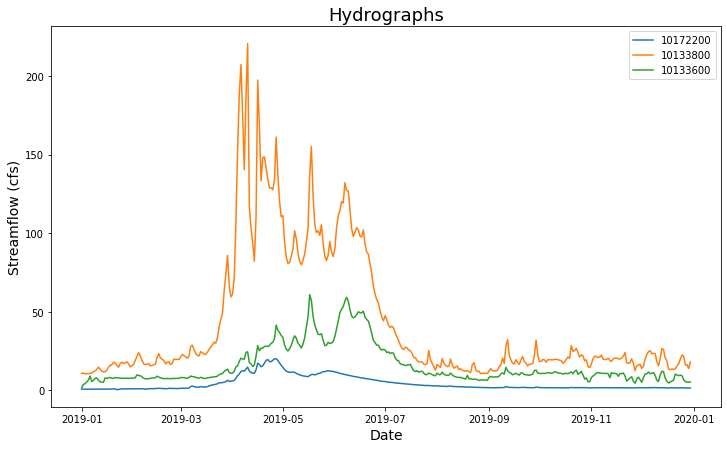

In [77]:
hydrographs(flow, NWISids)

In [ ]:
#Connect to Earth Engine to get NLDAS Temperature and Precipitation
import ee
import EE_funcs
ee.Authenticate()
ee.Initialize()

In [78]:
def dict_to_df(DF, temporal_resample, variable):
    kg_in = 0.04
    var_df = pd.DataFrame()
    for site in DF:
        DF[site].set_index('datetime', inplace = True)
        
        if variable == 'temperature':
            #make columns for Fahrenheit
            DF[site] = DF[site].resample(temporal_resample).max()
            DF[site].reset_index(inplace = True)
            DF[site]['temperature_F'] = (DF[site]['temperature']*9/5)+32 
            DF[site].pop('temperature')
            DF[site]['NWIS_site_id'] = site
        if variable == 'total_precipitation':
            DF[site] = DF[site].resample(temporal_resample).sum()
            DF[site].reset_index(inplace = True)
            #make columns for inches
            DF[site]['precipitation_in'] = DF[site]['total_precipitation']*kg_in
            DF[site].pop('total_precipitation')
            DF[site]['NWIS_site_id'] = site
            
        var_df = var_df.append(DF[site])
    
    var_df.reset_index(inplace=True, drop=True)
    return var_df, DF
            
            

## For fun, define a fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

In [79]:
#Tell the model what source to get
Source = 'NLDAS'

print('Getting ', Source, ' temperature and precipitation data')
#NLDAS temperature
temp = ee.ImageCollection('NASA/'+Source+'/FORA0125_H002').select('temperature').filterDate(start, end)

#NLDAS precipitation
precip = ee.ImageCollection('NASA/'+Source+'/FORA0125_H002').select('total_precipitation').filterDate(start, end)

# Define locations of interest, lets use the USGS guage locations!
lon = {}
lat = {}
poi = {}

print('Getting location criteria')
for site in np.arange(0,len(NWISids),1):
    lon[site] = StreamStats['Long'][site]
    lat[site] = StreamStats['Lat'][site]
    poi[site] = ee.Geometry.Point(lon[site], lat[site])

scale = 1000  # scale in meters

# Get the data for the pixel intersecting the point at each station
print('Getting temperature and precipitation for locations')
temp_poi = {}
precip_poi = {}
for site in np.arange(0,len(NWISids),1):
    name = StreamStats['NWIS_site_id'][site]
    temp_poi[name] = temp.getRegion(poi[site], scale).getInfo()
    precip_poi[name] = precip.getRegion(poi[site], scale).getInfo()


#Convert pointer object array to dataframe to work with
print('Converting data from object to dataframes')
temp = {}
precip = {}
for site in np.arange(0,len(NWISids),1):
    name = StreamStats['NWIS_site_id'][site]
    temp[name] = EE_funcs.ee_array_to_df(temp_poi[name],['temperature'])
    precip[name] = EE_funcs.ee_array_to_df(precip_poi[name],['total_precipitation'])
    #need to add in time to precip data, same daterange as temperaure
    precip[name]['time'] = temp[name]['time']
    
#resample to the desired temporal scale, take the respective statistic from the data of resampling
print('Converting to a single dataframe')
temporal_resample = 'D'

T, T_DF = dict_to_df(temp, temporal_resample, 'temperature')
P, P_DF = dict_to_df(precip, temporal_resample, 'total_precipitation')

for site in NWISids:
     #need to add in time to precip data, same daterange as temperaure
    P_DF[site]['time'] = T_DF[site]['time']

Clim_DF = pd.merge(T, P,on=['datetime', 'NWIS_site_id'])
Clim_DF.pop('time')
Clim_DF

Getting  NLDAS  temperature and precipitation data
Getting location criteria
Getting temperature and precipitation for locations
Converting data from object to dataframes
Converting to a single dataframe


,datetime,temperature_F,NWIS_site_id,precipitation_in
0,2019-01-01,14.82800,10172200,0.000216
1,2019-01-02,14.81000,10172200,0.000000
2,2019-01-03,24.00800,10172200,0.002224
3,2019-01-04,26.45600,10172200,0.003448
4,2019-01-05,32.34207,10172200,0.001140
...,...,...,...,...
1084,2019-12-25,28.56200,10133600,0.504736
1085,2019-12-26,25.48400,10133600,0.079812
1086,2019-12-27,22.87400,10133600,0.005784
1087,2019-12-28,17.31200,10133600,0.060808


In [80]:
T

,datetime,time,temperature_F,NWIS_site_id
0,2019-01-01,1546383600000,14.82800,10172200
1,2019-01-02,1546470000000,14.81000,10172200
2,2019-01-03,1546556400000,24.00800,10172200
3,2019-01-04,1546642800000,26.45600,10172200
4,2019-01-05,1546729200000,32.34207,10172200
...,...,...,...,...
1084,2019-12-25,1577314800000,28.56200,10133600
1085,2019-12-26,1577401200000,25.48400,10133600
1086,2019-12-27,1577487600000,22.87400,10133600
1087,2019-12-28,1577574000000,17.31200,10133600


In [81]:
def temp_precip_plt(P_DF, T_DF, NWISids):
    
    # Fitting curves.
    ## Optimize the parameters using a good start p0.
    lst0 = 20
    delta_lst = 40
    tau = 365*24*3600*1000   # milliseconds in a year
    phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0


    ## First, extract x values (times) from the dfs.
    x_data_t = {}
    y_data_t = {}
    params_t = {}
    params_covariance_t = {} 


    for site in NWISids:
        P_DF[site]['time'] = T_DF[site]['time']
        x_data_t[site] = np.asanyarray(T_DF[site]['time'].apply(float))  # temperature
        y_data_t[site] = np.asanyarray(T_DF[site]['temperature_F'].apply(float))  # temperature

        #Temperature
        params_t[site], params_covariance_t[site] = optimize.curve_fit(
            fit_func, x_data_t[site], y_data_t[site], p0=[lst0, delta_lst, tau, phi])


    # Subplots.
    fig, ax = plt.subplots(2,1, figsize=(10, 10))
    fig.patch.set_facecolor('white')


    #set colors #https://matplotlib.org/stable/gallery/color/named_colors.html
    color_t = ['orange','red', 'sienna'] 
    color_p = ['deepskyblue', 'steelblue', 'blue']


    for site in np.arange(0,len(NWISids),1):
        name = StreamStats['NWIS_site_id'][site]
        # Add temperature scatter plot.
        ax[0].scatter(T_DF[name]['datetime'], T_DF[name]['temperature_F'],
                   c=color_t[site], alpha=0.35, label=name)

        # Add temperature fitting curve.
        ax[0].plot(T_DF[name]['datetime'],
                fit_func(x_data_t[name], params_t[name][0], params_t[name][1], params_t[name][2], params_t[name][3]),
                color=color_t[site], lw=2.5)
    ax[0].hlines(y=32, xmin=min(T_DF[name]['datetime']), xmax=max(T_DF[name]['datetime']), linewidth=1, 
                     color='darkblue', label = 'freezing')

    # Add some parameters.
    ax[0].set_title('Temperature for Utah Watersheds', fontsize=16, pad=40)
    ax[0].set_xlabel('Date', fontsize=14)
    ax[0].set_ylabel('Temperature [$^\circ$F]', fontsize=14, color = 'red')
    ax[0].tick_params(axis='y', labelcolor='red')

    #add freezing pt horizontal line

    ax[0].grid(lw=0.2)
    ncol = len(NWISids)+1
    ax[0].legend(fontsize=14, loc='upper left', ncol = ncol, bbox_to_anchor=(0.07, 1.15))

    #now plot precipitation
    for site in np.arange(0,len(NWISids),1):
        name = StreamStats['NWIS_site_id'][site]
        # Add temperature scatter plot.
        ax[1].scatter(P_DF[name]['datetime'], P_DF[name]['precipitation_in'],
                   c=color_p[site], alpha=0.35, label=name)


    # Add some parameters.
    ax[1].set_title('Precipitation for Utah Watersheds', fontsize=16, pad=40)
    ax[1].set_xlabel('Date', fontsize=14)
    ax[1].set_ylabel('Precipitation [in]', fontsize=14, color = 'blue')
    ax[1].tick_params(axis='y', labelcolor='blue')

    ax[1].grid(lw=0.2)
    ncol = len(NWISids)+1
    ax[1].legend(fontsize=14, loc='upper left', ncol = ncol, bbox_to_anchor=(0.15, 1.15))



    fig.tight_layout()
    plt.show()

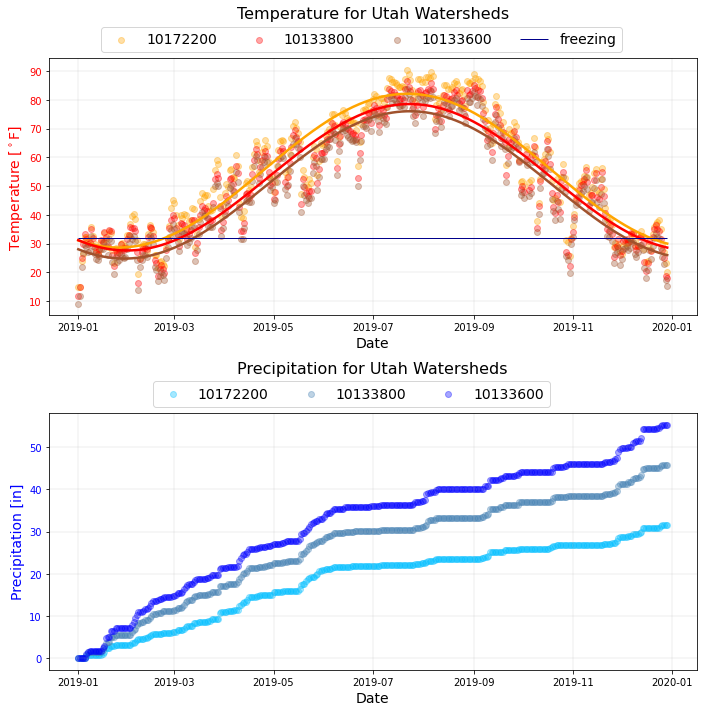

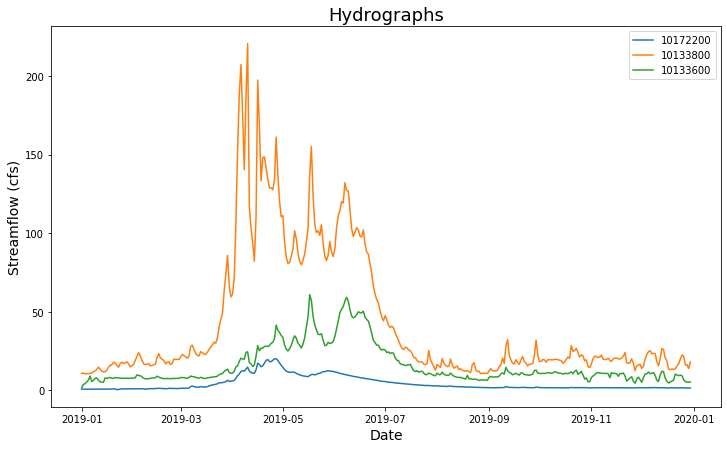

In [82]:
#Aggregate the precipitation per year
Precip_Total = {}
for site in NWISids:
    Precip_Total[site]=P_DF[site].copy()
    Precip_Total[site].set_index('datetime', inplace =True)
    Precip_Total[site].pop('time')
    Precip_Total[site]['Year'] = Precip_Total[site].index.year
    Precip_Total[site]['precipitation_in'] = Precip_Total[site].groupby(['Year'])['precipitation_in'].cumsum()
    Precip_Total[site].reset_index(inplace = True)
#lets plot again
temp_precip_plt(Precip_Total, T_DF, NWISids)
#lets plot the hydrographs again to see if we see any similarities
hydrographs(flow, NWISids)

## Create a DataFrame for input into ML model

We have looked at daily resolution temperature and precipitation, so lets stay at this resolution. 
The NLDAS data is available at 1 hr temporal resolution with the ability to resample to an greater timestep using the [resample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) function.

The [Merge, Join, Concatenate and Compare](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) functions will be most useful here.

In [83]:
#Lets make our final dataframe with climate, streamstats, and flow
#Connect Streamstats with the climate dataframe
Pred_DF = pd.merge(Clim_DF, StreamStats,on=['NWIS_site_id'])

#Day of year (DOY) is likely an important feature, lets convert date time to DOY
Pred_DF['DOY'] = Pred_DF.datetime.dt.dayofyear

#now add flow, first we covert flow from a dictionary to a dataframe
Flow_DF = pd.DataFrame()
for site in NWISids:
    Flow_DF = Flow_DF.append(flow[site])
Flow_DF.reset_index(inplace = True)    
Pred_DF = pd.merge(Pred_DF, Flow_DF,on=['datetime', 'NWIS_site_id'])

#What feature are relevant. Lets remove NWIS_site_id
Pred_DF.pop('NWIS_site_id')

#remove old datetime column
Pred_DF.pop('datetime')

#save DataFrame for Model Development
Pred_DF.to_csv('./Data/Pred_DF_RJ.csv')

In [84]:
Pred_DF

,temperature_F,precipitation_in,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,DOY,flow_cfs
0,14.82800,0.000216,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,1,0.860870
1,14.81000,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,2,0.850000
2,24.00800,0.002224,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,3,0.850000
3,26.45600,0.003448,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,4,0.850000
4,32.34207,0.001140,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,5,0.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,28.56200,0.504736,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,359,9.320729
1085,25.48400,0.079812,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,360,6.870729
1086,22.87400,0.005784,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,361,5.743553
1087,17.31200,0.060808,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,362,5.310652


## Scale the DataFrame and make predictions

Set up the DataFrame for predictions, i.e., remote flow observations and scale the model input variables.

In [85]:
#Split the data into features and target
y = Pred_DF['flow_cfs']

#remove target from features
Pred_DF.pop('flow_cfs')

X = Pred_DF

#scale the predictor inputs
#load the scalers
scaler_x = pickle.load(open('./Model/XGBoost/scaler_x_RJ.pkl', 'rb'))
scaler_y = pickle.load(open('./Model/XGBoost/scaler_y_RJ.pkl', 'rb'))

#apply the scaler to the X_testing data
X_scaled = scaler_x.transform(X)

#Load the original model
model = pickle.load(open('./Model/XGBoost/Model_RJ.dat', "rb"))

# make a prediction
y_pred = model.predict(X_scaled)
    
#scale the predictions back to streamflow in cfs and convert to pandas DataFrame
y_pred = pd.DataFrame(scaler_y.inverse_transform(pd.DataFrame(y_pred)),columns = ['flow_cfs_pred'])
y = pd.DataFrame(y, columns = ['flow_cfs'])

#Load the optimized model, remember to change it ot the correction one!
model = pickle.load(open('./Model/XGBoost/Model_HyperParam_RJ.dat', "rb"))

# make a prediction
y_pred_Hyp = model.predict(X_scaled)
    
#scale the predictions back to streamflow in cfs and convert to pandas DataFrame
y_pred_Hyp = pd.DataFrame(scaler_y.inverse_transform(pd.DataFrame(y_pred_Hyp)),columns = ['flow_cfs_Hyp_pred'])


#Combine X_test, y_pred, and y_test DataFrames to evaluate the performance of the model
#reset indexes
DFs = [y_pred_Hyp, y_pred, y, X]
for df in DFs:
    df.reset_index(drop = True, inplace = True)
    
#merge
Eval_DF = pd.concat(DFs, axis=1)

Eval_DF
    
#merge
Eval_DF = pd.concat(DFs, axis=1)

Eval_DF

,flow_cfs_Hyp_pred,flow_cfs_pred,flow_cfs,temperature_F,precipitation_in,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,DOY
0,0.482556,-0.200619,0.860870,14.82800,0.000216,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,1
1,0.596233,0.320484,0.850000,14.81000,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,2
2,0.718705,0.898722,0.850000,24.00800,0.002224,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,3
3,1.088066,0.558509,0.850000,26.45600,0.003448,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,4
4,1.219224,0.719943,0.850000,32.34207,0.001140,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,6.093199,7.022478,9.320729,28.56200,0.504736,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,359
1085,5.101537,4.447096,6.870729,25.48400,0.079812,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,360
1086,4.339446,4.562869,5.743553,22.87400,0.005784,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,361
1087,4.734463,4.071430,5.310652,17.31200,0.060808,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5,362


## Comparision of hydrological models

We can find the evaluation functions from Chapter 2 in the Evaluation_funcs.py file and import them in the interactive python file to A) clean up our notebook and B) evaluate the performance of different models.

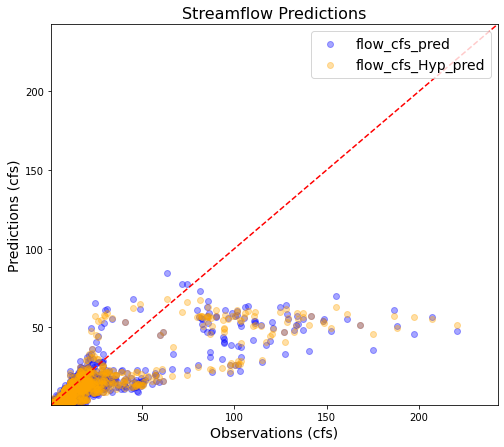

RMSE for  flow_cfs_pred  is  22.201002  cfs
RMSE for  flow_cfs_Hyp_pred  is  21.827486  cfs
Mean Absolute Percentage Error for  flow_cfs_pred  is  44.01 %
Mean Absolute Percentage Error for  flow_cfs_Hyp_pred  is  40.91 %
Percentage Bias for  flow_cfs_pred  is  42.14 %
Percentage Bias for  flow_cfs_Hyp_pred  is  41.52 %
Kling-Glutz Efficiency for  flow_cfs_pred  is  0.3
Kling-Glutz Efficiency for  flow_cfs_Hyp_pred  is  0.31


In [86]:
import Evaluation_funcs

#Evaluate model performance of the different models
prediction_columns = ['flow_cfs_pred', 'flow_cfs_Hyp_pred']

#plot the predictions
Evaluation_funcs.Model_Evaluation_Plots(Eval_DF, prediction_columns)

#Get RMSE from the model
Evaluation_funcs.RMSE(Eval_DF, prediction_columns)

#Get Mean Absolute Percentage Error from the model
Evaluation_funcs.MAPE(Eval_DF, prediction_columns)

#Get Percent Bias from the model
Evaluation_funcs.PBias(Eval_DF, prediction_columns)

#Get Kling-Gutz Efficiency from the model
Evaluation_funcs.KGE(Eval_DF, prediction_columns)

## That was not the model performance we were expecting
Let's investigate!

In [87]:
#separate streamflow predictions by location
#Keep key columns to merge Streamstats back in, need to connect lat long with NWISids
cols = ['flow_cfs_Hyp_pred', 'flow_cfs_pred', 'flow_cfs', 'DOY', 'Lat', 'Long']
DF = Eval_DF[cols]

#Merge on Lat,Long
DF = pd.merge(DF, StreamStats,on=['Lat', 'Long'])



 Plotting Streamflow Predictions for NWIS site:  10172200


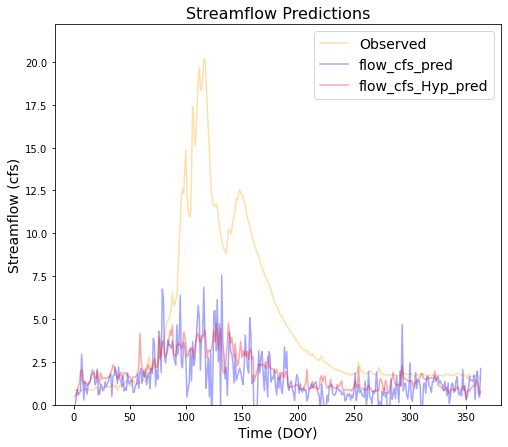

RMSE for  flow_cfs_pred  is  4.922723  cfs
RMSE for  flow_cfs_Hyp_pred  is  4.5831013  cfs
Mean Absolute Percentage Error for  flow_cfs_pred  is  59.65 %
Mean Absolute Percentage Error for  flow_cfs_Hyp_pred  is  52.53 %
Percentage Bias for  flow_cfs_pred  is  65.15 %
Percentage Bias for  flow_cfs_Hyp_pred  is  57.77 %
Kling-Glutz Efficiency for  flow_cfs_pred  is  -0.08
Kling-Glutz Efficiency for  flow_cfs_Hyp_pred  is  0.0

 Plotting Streamflow Predictions for NWIS site:  10133800


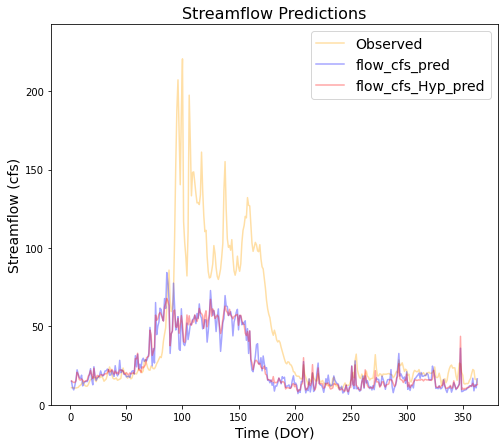

RMSE for  flow_cfs_pred  is  36.38739  cfs
RMSE for  flow_cfs_Hyp_pred  is  35.824387  cfs
Mean Absolute Percentage Error for  flow_cfs_pred  is  37.05 %
Mean Absolute Percentage Error for  flow_cfs_Hyp_pred  is  36.7 %
Percentage Bias for  flow_cfs_pred  is  40.71 %
Percentage Bias for  flow_cfs_Hyp_pred  is  40.76 %
Kling-Glutz Efficiency for  flow_cfs_pred  is  0.24
Kling-Glutz Efficiency for  flow_cfs_Hyp_pred  is  0.24

 Plotting Streamflow Predictions for NWIS site:  10133600


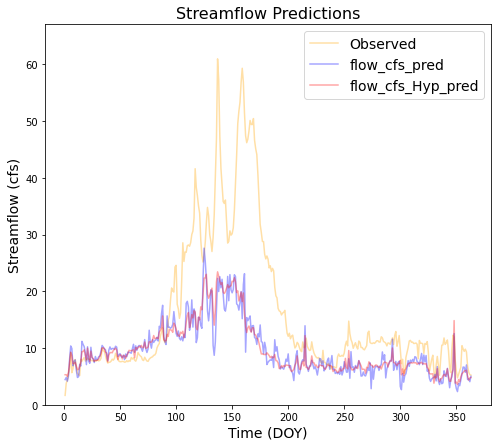

RMSE for  flow_cfs_pred  is  11.418318  cfs
RMSE for  flow_cfs_Hyp_pred  is  11.177034  cfs
Mean Absolute Percentage Error for  flow_cfs_pred  is  35.34 %
Mean Absolute Percentage Error for  flow_cfs_Hyp_pred  is  33.51 %
Percentage Bias for  flow_cfs_pred  is  39.57 %
Percentage Bias for  flow_cfs_Hyp_pred  is  39.04 %
Kling-Glutz Efficiency for  flow_cfs_pred  is  0.21
Kling-Glutz Efficiency for  flow_cfs_Hyp_pred  is  0.22


In [88]:
for site in NWISids:
    #get the predictions for each location
    plot_df = DF[DF['NWIS_site_id'] == site]
    print('\n Plotting Streamflow Predictions for NWIS site: ', site)
    #plot
    Evaluation_funcs.Hydrograph_Evaluation_Plots(plot_df, prediction_columns)
    #Get RMSE from the model
    Evaluation_funcs.RMSE(plot_df, prediction_columns)

    #Get Mean Absolute Percentage Error from the model
    Evaluation_funcs.MAPE(plot_df, prediction_columns)

    #Get Percent Bias from the model
    Evaluation_funcs.PBias(plot_df, prediction_columns)

    #Get Kling-Gutz Efficiency from the model
    Evaluation_funcs.KGE(plot_df, prediction_columns)

## Why is the model not capturing the high flow rates?
